# Digital Musicology (DH-401)
## Assignment 1: Discovering meter
Group 6
- Mickaël Achkar
- Yichen Wang
- Yinghui Jiang

In [1]:
import ms3
import pandas as pd
import numpy as np
import math
import fractions
import matplotlib.pyplot as plt
from scipy.fftpack import rfft, rfftfreq
from scipy.signal import find_peaks, get_window
from statsmodels.graphics.tsaplots import plot_acf
import statsmodels.api as sm
from sklearn.model_selection import train_test_split, validation_curve
from sklearn.ensemble import RandomForestClassifier  
from sklearn import metrics
from collections import Counter

## 0. Dataset preparation

In [2]:
# This is the time unit of 'global_onset' used in the dataset
time_unit = 1/4

meter_dataset = pd.read_csv('DM2022 - Assignment 1 [Dataset].csv', index_col = 0, converters = {'global_onset':fractions.Fraction, 'duration': fractions.Fraction})
meter_dataset = meter_dataset[['piece', 'staff', 'timesig', 'voice', 'global_onset', 'duration', 'tied', 'gracenote']]

# Ignore gracenotes for now
meter_dataset = meter_dataset[meter_dataset['gracenote'].isna()].drop(columns = ['gracenote'])

# Sort dataset
meter_dataset = meter_dataset.sort_values(by=['piece', 'staff', 'voice', 'global_onset']).reset_index(drop=True)

# Get maximum bar length of the dataset for analysis later on
timesignatures = [fractions.Fraction(timesig) for timesig in meter_dataset['timesig']]
max_bar_length = max(timesignatures)

In [3]:
%%time

untied_df = meter_dataset
tied_df = meter_dataset

# Aggregating ties (to verify if this is worse or better)
blocks = (tied_df.tied.ne(tied_df.tied.shift()) & tied_df.tied.ne(tied_df.tied.shift() - 2) & tied_df.tied.ne(tied_df.tied.shift() - 1)).cumsum()
tied_df = tied_df.groupby(blocks, as_index=False).agg({'piece':'first', 'staff':'first', 'voice':'first', 'timesig':'first', 'global_onset':'first', 'duration':'sum', 'tied':'first'})

CPU times: user 205 ms, sys: 27 ms, total: 232 ms
Wall time: 240 ms


In [4]:
#df = tied_df
df = untied_df

## 1. For one piece and staff

### a. From musical score to metrical weights

In [5]:
# Select a random piece and staff (time signature may change per staff)
random_piece_staff = df[['piece', 'staff']].sample(n=1).to_records(index=False)
key = tuple(random_piece_staff[0])

random_piece_staff_df = df[(df['piece'] == key[0]) & (df['staff'] == key[1])]

# To fine-tune sampling, get minimum note duration among all notes in the piece/staff
min_note = float(random_piece_staff_df['duration'].min())
print("Smallest note length in dataset:", fractions.Fraction(min_note).limit_denominator(1000))

sampling_period = min_note/time_unit
total_piece_duration = random_piece_staff_df['global_onset'].max()

# Partition the global_onsets in bins
bins = np.arange(0, (total_piece_duration+sampling_period+1e-10), sampling_period)
binned_onsets = pd.cut(random_piece_staff_df['global_onset'], bins, right = False)

# Compute the sum of durations of all events with onsets in each bin
summed_durations = random_piece_staff_df.groupby(binned_onsets)['duration'].sum().apply(float)

random_piece_staff_df

Smallest note length in dataset: 1/32


,piece,staff,timesig,voice,global_onset,duration,tied
61110,K332-1,1,3/4,1,0,1/2,NaN
61111,K332-1,1,3/4,1,2,1/4,NaN
61112,K332-1,1,3/4,1,3,1/2,NaN
61113,K332-1,1,3/4,1,5,1/4,NaN
61114,K332-1,1,3/4,1,6,1/2,NaN
...,...,...,...,...,...,...,...
62500,K332-1,1,3/4,3,45/2,1/8,NaN
62501,K332-1,1,3/4,3,23,1/4,NaN
62502,K332-1,1,3/4,3,418,1/8,NaN
62503,K332-1,1,3/4,3,837/2,1/8,NaN


Metrical weights of Piece: K332-1, Staff: 1, Time Signature: 3/4


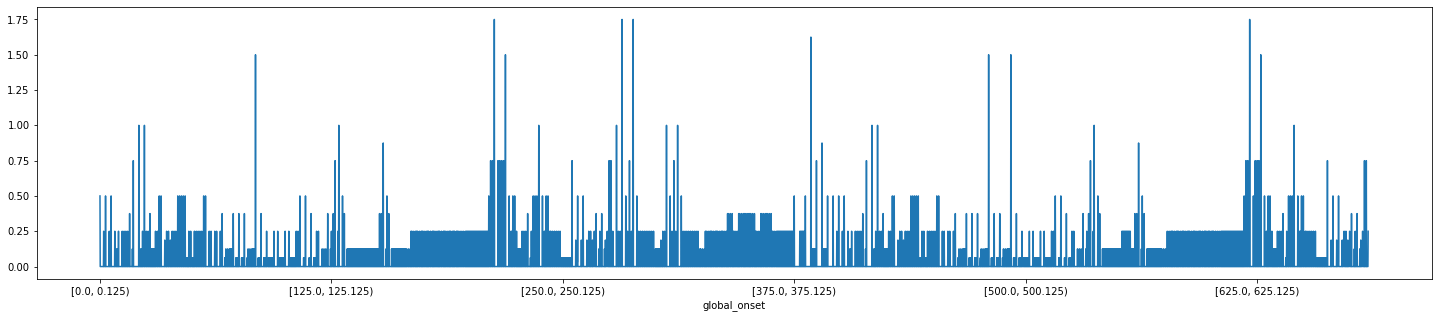

In [6]:
# Now we can plot the metrical weights of this piece

# Get timesignature for reference
timesig = random_piece_staff_df['timesig'].iloc[0]

print("Metrical weights of Piece: {piece}, Staff: {staff}, Time Signature: {timesig}".format(piece = key[0], staff = key[1], timesig=timesig))

# Plot metrical weights
summed_durations.plot(figsize=(25,5));

### b. From metrical weights to periodicities

In [7]:
def top_frequencies(summed_durations_piece_staff, n_tops, plot=False):
    x = summed_durations_piece_staff.index.to_list()
    y = summed_durations_piece_staff.to_list()

    # Number of sample points
    N = len(x)
    # Sample spacing (in units of time_unit)
    T = x[1].left

    ################################################################
    # Window the signal to reduce spectral leakage in the FFT (a good practise)
    window = get_window('hann', N)

    # Compute Fourier transform of signal
    yf = rfft(y * window)
    xf = rfftfreq(N, T)
    # Convert frequencies to units of cycles/whole note
    xf = xf/time_unit
    # Convert Fourier output to real-valued amplitudes
    amplitudes = np.abs(yf)

    # Find significant peaks (using min distance between neighbouring peaks)
    peaks, _ = find_peaks(amplitudes, distance=N*.07)

    ##### Get top n_tops frequencies (and periods) #####
    fourier_peaks = np.array(tuple(zip(xf[peaks], 1/xf[peaks], amplitudes[peaks])))
    # Create DataFrame
    fourier_df = pd.DataFrame(fourier_peaks, columns = ['frequency (cycles/whole note)', 'period (1/f)', 'amplitude'])
    # Convert period (1/f) to Fractions
    fourier_df['period (1/f)'] = [fractions.Fraction(period).limit_denominator(100) for period in fourier_df['period (1/f)']]
    # Sort in descending order
    fourier_df_sorted = fourier_df.sort_values(by='amplitude', ascending=False).head(n_tops)
    tops = fourier_df_sorted['period (1/f)'].to_numpy()
        
    if plot:
        plt.plot(xf, amplitudes)
        plt.plot(xf[peaks], amplitudes[peaks], "x")
        plt.xlabel('Frequencies [cycles/whole note]')
        plt.ylabel('Amplitude')
        plt.grid()
        plt.show()
        print("Top {} or less frequencies and periods".format(n_tops))
        print(fourier_df_sorted)
        
    return tops

def top_autocorrelations(summed_durations_piece_staff, n_tops, plot=False):
    x = summed_durations_piece_staff.index.tolist()
    y = summed_durations_piece_staff.tolist()
    
    # Number of sample points
    N = len(x)
    # Sample spacing (in units of time_unit)
    T = x[1].left
    
    ################################################################
    # Create a window with the first few lags
    # The lags captured will correspond to 6 whole notes (least amount needed for ACF coefficients duple/triple criteron formula)
    nlags = math.ceil(6 / (T*time_unit))
    # The plotting and ranking window will correspond to the maximum duration of a bar in the whole dataset (ACF confidence interval decreases with lags)
    ranking_window = math.ceil(max_bar_length / (T*time_unit))

    ##### Get top n_tops autocorrelations #####
    autocorr = sm.tsa.acf(y, nlags=nlags)
    # Convert lags in units of whole notes
    converted_lags = range(len(autocorr)) * (T*time_unit)
    # Create DataFrame
    autocorr_df = pd.DataFrame(tuple(zip(converted_lags, autocorr)), columns = ['lag (whole notes)','autocorrelation'])
    # Convert lags to Fractions
    autocorr_df['lag (whole notes)'] = [fractions.Fraction(onset).limit_denominator(100) for onset in autocorr_df['lag (whole notes)']]
    # Sort in descending order
    autocorr_df_sorted = autocorr_df.head(ranking_window).sort_values(ascending=False, by='autocorrelation').where(autocorr_df.autocorrelation > 0).dropna().drop(0).head(n_tops)
    tops = autocorr_df_sorted['lag (whole notes)'].to_numpy()
    
    # Distinction between Duple/Triple meters: use ACF average coefficients formula
    coeffs = {}
    for beat_unit in [1/2, 1/4, 1/8]:
        n = math.floor(beat_unit/(T*time_unit))
        duple = (autocorr_df.iloc[2*n,1] + autocorr_df.iloc[4*n,1] + autocorr_df.iloc[8*n,1]) / 3
        triple = (autocorr_df.iloc[3*n,1] + autocorr_df.iloc[6*n,1] + autocorr_df.iloc[12*n,1]) / 3
        coeffs[fractions.Fraction(beat_unit)] = duple - triple
            
    if plot:
        plot_acf(y, lags=ranking_window)
        plt.xlabel('Lag [{} notes]'.format(fractions.Fraction(T*time_unit).limit_denominator(100)))
        plt.ylabel('Autocorrelation')
        plt.grid()
        plt.show()
        print("Top {} or less autocorrelations".format(n_tops))
        print(autocorr_df_sorted)
        
    return tops, coeffs

Periodicity analysis of Piece: K332-1, Staff: 1, Time Signature: 3/4


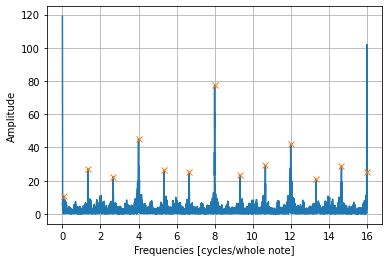

Top 7 or less frequencies and periods
    frequency (cycles/whole note) period (1/f)  amplitude
6                        7.998540          1/8  77.618225
3                        3.999270          1/4  44.989815
9                       11.997811         1/12  41.956418
8                       10.666667         3/32  29.223737
11                      14.665937         3/44  28.730026
1                        1.331144          3/4  27.257288
4                        5.330414         3/16  26.419278


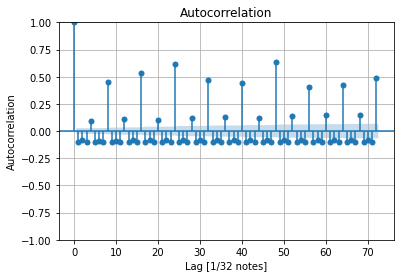

Top 7 or less autocorrelations
   lag (whole notes)  autocorrelation
48               3/2         0.634895
24               3/4         0.613184
16               1/2         0.538553
32                 1         0.466863
8                1/4         0.453260
40               5/4         0.441128
64                 2         0.427859


In [8]:
print("Periodicity analysis of Piece: {piece}, Staff: {staff}, Time Signature: {timesig}".format(piece = key[0], staff = key[1], timesig=timesig))

top_frequencies(summed_durations, n_tops=7, plot=True)
top_autocorrelations(summed_durations, n_tops=7, plot=True);

## 2. Full dataset classification pipeline

### a. Metrical weights

In [9]:
%%time

# For all pieces and staves (This operation takes around 2-3 minutes on our computer)

# Create dictionaries of total piece durations and smallest notes in each piece/staff
total_piece_durations_df = df.groupby(['piece','staff'])['global_onset'].max().apply(float)
minimum_note_durations_df = df.groupby(['piece','staff'])['duration'].min().apply(float)
total_piece_durations = total_piece_durations_df.to_dict()
minimum_note_durations = minimum_note_durations_df.to_dict()

summed_durations_dict = {}
for key,value in total_piece_durations.items():
    piece_staff = df[(df['piece'] == key[0]) & (df['staff'] == key[1])]

    min_note = minimum_note_durations[key]
    sampling_period = min_note/time_unit

    bins = np.arange(0, (value+sampling_period+1e-10), sampling_period)
    binned_onsets = pd.cut(piece_staff['global_onset'], bins, right = False)
    summed_durations_dict[key] = piece_staff.groupby(binned_onsets)['duration'].sum().apply(float)

CPU times: user 1min 40s, sys: 1.74 s, total: 1min 42s
Wall time: 1min 55s


### b. Building features dataset: Periodicities

In [10]:
%%time

# Build ground truth time signature dataset
ground_truth_df = df.groupby(['piece', 'staff'], as_index=False).first().drop(columns=['voice','global_onset','tied','duration'])

# Gather features: top n autocorrelations and frequencies
n_tops_autocorr = 8
n_tops_freq = 5
periodicities = []
for i in ground_truth_df.itertuples():
    key = (i.piece, i.staff)
    summed_durations_piece_staff = summed_durations_dict[key]
    tops_autocorr, coeffs = top_autocorrelations(summed_durations_piece_staff, n_tops_autocorr)
    tops_freq = top_frequencies(summed_durations_piece_staff, n_tops_freq)
    features = [*tops_autocorr, *tops_freq, *coeffs.values()]
    periodicities.append(features)
    
features_df = pd.DataFrame(periodicities)

ground_truth_and_features_df = pd.concat([ground_truth_df, features_df], axis=1)
# Fill NaNs with mean of sample features or with 0s
#ground_truth_and_features_df = ground_truth_and_features_df.T.fillna(ground_truth_and_features_df.iloc[:,3:].mean(axis=1)).T
ground_truth_and_features_df = ground_truth_and_features_df.fillna(0)

# Get features and labels 
X = ground_truth_and_features_df.iloc[:,3:].values
y = ground_truth_and_features_df.iloc[:,2].values

ground_truth_and_features_df

CPU times: user 9.56 s, sys: 362 ms, total: 9.92 s
Wall time: 13.4 s


,piece,staff,timesig,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,K279-1,1,4/4,1,2,1/4,1/2,3/2,3/4,5/4,7/4,1/8,1/4,1/12,1/16,1/2,0.154796,0.165688,0.189548
1,K279-1,2,4/4,2,1/4,1/2,7/4,1,3/2,1/8,3/4,1/4,31/33,1/2,1/6,16/81,0.163630,0.173697,0.171674
2,K279-2,1,3/4,3/4,1/4,1/2,3/2,5/4,1,7/4,2,1/12,1/8,1/4,74/99,3/44,-0.119920,-0.081835,0.134694
3,K279-2,2,3/4,1/4,3/4,1/2,3/2,1,5/4,2,218/97,1/4,995/36,32/33,77/39,30/83,0.018164,-0.006570,-0.345994
4,K279-3,1,2/4,1/2,1,2,3/2,1/8,1/4,17/8,9/8,1/6,1/2,1/4,12/95,83/77,0.107614,0.199445,0.179263
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
383,n16op135_03,4,6/8,3/4,3/8,3/2,9/8,15/8,17/8,7/4,2,3/8,3/16,12/95,83/95,1/4,-0.378025,-0.537130,-0.642430
384,n16op135_04,1,3/2,2,1,3/2,1/2,1/4,3/4,7/4,5/4,1/4,1/2,1/6,1/8,1/7,0.105089,0.160427,0.258956
385,n16op135_04,2,3/2,2,1/2,3/2,1,1/4,3/4,7/4,5/4,1/2,1/4,1/3,101/100,2293/80,0.039016,0.149358,0.289164
386,n16op135_04,3,3/2,1,2,1/2,3/2,7/4,5/4,3/4,1/4,1/2,1/4,101/100,1/3,2293/80,0.161078,0.203221,0.267732


### c. From periodicities to time signature: Classification (Random Forest)

In [11]:
# Split training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=None)

# Train model
model = RandomForestClassifier(n_estimators=100, bootstrap=True)
model.fit(X_train, y_train)

# Test model
y_pred = model.predict(X_test)
print("Accuracy: {}\n".format(metrics.accuracy_score(y_test, y_pred)))

# Get summary of prediction results
wrong_predictions = y_test[y_test!=y_pred]
correct_predictions = y_test[y_test==y_pred]
confusions = [frozenset(confusion) for confusion in zip(y_test[y_test!=y_pred], y_pred[y_test!=y_pred])]

print("Confusions counts:\n{}\n".format(Counter(confusions)))
print("Wrong predicitons counts:\n{}\n".format(Counter(wrong_predictions)))
print("Correct predictions counts:\n{}\n".format(Counter(correct_predictions)))

Accuracy: 0.7216494845360825

Confusions counts:
Counter({frozenset({'2/4', '4/4'}): 8, frozenset({'2/2', '4/4'}): 3, frozenset({'2/2', '3/4'}): 3, frozenset({'2/4', '2/2'}): 3, frozenset({'4/4', '3/4'}): 3, frozenset({'2/4', '3/4'}): 2, frozenset({'9/8', '6/8'}): 2, frozenset({'3/8', '3/4'}): 1, frozenset({'6/8', '3/4'}): 1, frozenset({'12/8', '6/8'}): 1})

Wrong predicitons counts:
Counter({'2/2': 9, '4/4': 6, '3/4': 5, '2/4': 3, '9/8': 2, '3/8': 1, '12/8': 1})

Correct predictions counts:
Counter({'3/4': 19, '2/2': 17, '2/4': 17, '6/8': 7, '4/4': 6, '3/8': 4})



### d. Evaluation of model

/Users/mukqs/Documents/Spring-2022/Digital-Musicology/Assignment-1/dm-meter-timesig/venv/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=10.
  warnings.warn(


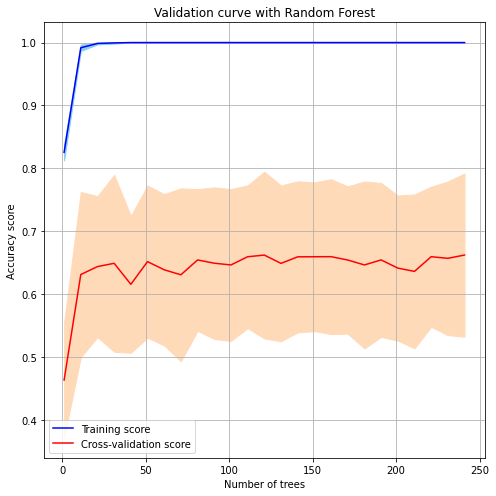

CPU times: user 1min 22s, sys: 2.18 s, total: 1min 24s
Wall time: 1min 35s


In [12]:
%%time

# Cross-validation curve
n_trees_range=np.arange(1, 250, 10)

train_scores, test_scores = validation_curve(RandomForestClassifier(), X, y, param_name="n_estimators", param_range=n_trees_range, cv=10, scoring='accuracy')
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.subplots(1, figsize=(7,7))
plt.plot(n_trees_range, train_mean, label="Training score", color="blue")
plt.plot(n_trees_range, test_mean, label="Cross-validation score", color="red")

plt.fill_between(n_trees_range, train_mean - train_std, train_mean + train_std, color="skyblue")
plt.fill_between(n_trees_range, test_mean - test_std, test_mean + test_std, color="peachpuff")

plt.title("Validation curve with Random Forest")
plt.xlabel("Number of trees")
plt.ylabel("Accuracy score")
plt.tight_layout()
plt.legend(loc="best")
plt.grid()
plt.show()